<a href="https://colab.research.google.com/github/KNL1979/DS807/blob/main/Part2_Shallow_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading libraries

In [ ]:
import tensorflow as tf

#import wandb
#from wandb.keras import WandbCallback

import pandas as pd
#import requests
import random
import gzip
import json
import io
import os
import numpy as np
import matplotlib.pyplot as plt

import psutil

from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as score

# Setting up with Google Drive

In [ ]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Replace '------' with the path such that "DM890_assignment_1" is your working directory
%cd '/content/gdrive/My Drive/AML_Exam/Problem2'

/content/gdrive/.shortcut-targets-by-id/1osKmyrDLORFSpes1mwrU-W7OXM-to6bK/AML_Exam/Problem2


# Function to sample the data, and data paths

In [ ]:
def dataset_name(file_path):
  dataset_name = os.path.splitext(os.path.basename(file_path))[0].replace('_5.json', '')
  return dataset_name

In [ ]:
def loading_gz(file_path, printing = False, load_all = False, max_load_samples = np.inf, max_samples_per_cat = 2000):
  my_keys = ['overall', 'reviewText', 'summary']
  with gzip.open(file_path, 'rt', encoding='utf-8') as g:
          # Initialize an empty list to store sampled rows
          sampled_data = []
          for i, line in enumerate(g):
              if printing:
                if i % 1000 == 0:
                    print(i)
              data = json.loads(line)
              sampled_data.append({k: data[k] for k in my_keys & data.keys()})
              if i > max_load_samples:
                break
          sampled_data = pd.DataFrame(sampled_data)
          sampled_data.dropna(inplace = True)

          if load_all:
            return sampled_data

          nMax = sampled_data.groupby('overall').count().min()[0] * 3
          #my_max = min(nMax, 2000)
          res = sampled_data.groupby('overall').apply(lambda x: x.sample(n = min(nMax, len(x), max_samples_per_cat))).reset_index(drop = True)

          return res.sample(frac=1)


In [ ]:
# List of file paths for your 29 datasets
file_paths_train = [
    '/content/gdrive/My Drive/AML_Exam/Problem2/data/Arts_Crafts_and_Sewing_5.json.gz',
    '/content/gdrive/My Drive/AML_Exam/Problem2/data/Prime_Pantry_5.json.gz'
]

path_val  = '/content/gdrive/My Drive/AML_Exam/Problem2/data/All_Beauty_5.json.gz'

path_test = '/content/gdrive/My Drive/AML_Exam/Problem2/data/Luxury_Beauty_5.json.gz'

data_path_dict = {dataset_name(k):k for k in file_paths_train}


## Defining Encoding function

In [ ]:
def my_encoder(x_train, x_test = None, MAX_VOCAB_SIZE = 1000, OUTPUT_LENGTH = None):
  encoder = tf.keras.layers.TextVectorization(max_tokens=MAX_VOCAB_SIZE, output_sequence_length = OUTPUT_LENGTH)
  encoder.adapt(x_train)
  # vocab = np.array(encoder.get_vocabulary())

  encoded_x = encoder(x_train)

  if not pd.isnull(x_test).all():
    encoded_x_test = encoder(x_test)
    return encoded_x, encoded_x_test
  else:
    return encoded_x

In [ ]:
data_path_dict

{'Arts_Crafts_and_Sewing': '/content/gdrive/My Drive/AML_Exam/Problem2/data/Arts_Crafts_and_Sewing_5.json.gz',
 'Prime_Pantry': '/content/gdrive/My Drive/AML_Exam/Problem2/data/Prime_Pantry_5.json.gz'}

# Shallow Learing - SVM


In [ ]:
train_name = 'Arts_Crafts_and_Sewing'
load_train = loading_gz(data_path_dict[train_name], max_load_samples = 100000, max_samples_per_cat=2000)
x_train = load_train['reviewText']
y_train = load_train['overall']-1 #the minus 1 is to adjust for the output of the model being [0,4]

load_val = loading_gz(path_val, load_all=True)
x_val = load_val['reviewText']
y_val = load_val['overall']-1  #the minus 1 is to adjust for the output of the model being [0,4]

encoded_train, encoded_val  = my_encoder(x_train, x_val, MAX_VOCAB_SIZE = 1500, OUTPUT_LENGTH = 100)


train_feat, train_label = encoded_train, y_train

val_feat, val_label = encoded_val, y_val

In [ ]:
load_test = loading_gz(path_test, load_all=True)
x_test = load_test['reviewText']
y_test = load_test['overall']-1  #the minus 1 is to adjust for the output of the model being [0,4]

_, encoded_test  = my_encoder(x_train, x_test, MAX_VOCAB_SIZE = 1500, OUTPUT_LENGTH = 100)

In [ ]:
#--------------------------------------------------
#       Train and Evaluate SVM
#--------------------------------------------------

#accuracy_lin = []
accuracy_poly = []
accuracy_rbf = []
accuracy_sig = []
#gamma in np.arange(0.01, 1, 0.01)
#c in np.arange(0.5, 10, 0.1)
gamma = 0.08
#c = 3

c_range = np.linspace(1, 50, 10)

for c in c_range:
    #linear = svm.SVC(kernel='linear', C=c, decision_function_shape='ovr').fit(train_feat, train_label)
    #rbf = svm.SVC(kernel='rbf', gamma=gamma, C=c, decision_function_shape='ovr').fit(train_feat, train_label)
    poly = svm.SVC(kernel='poly', degree=3, C=c, decision_function_shape='ovr').fit(train_feat, train_label)
    sig = svm.SVC(kernel='sigmoid', C=c, decision_function_shape='ovr').fit(train_feat, train_label)

    #accuracy_lin.append(linear.score(test_feat, test_label))
    accuracy_poly.append(poly.score(train_feat, train_label))
    #accuracy_rbf.append(rbf.score(train_feat, train_label))
    accuracy_sig.append(sig.score(train_feat, train_label))
    print(c)
    # print("Accuracy Linear Kernel:", accuracy_lin)
    # print("Accuracy Polynomial Kernel:", accuracy_poly)
    # print("Accuracy Radial Basis Kernel:", accuracy_poly)
    # print("Accuracy Sigmoid Kernel:", accuracy_sig)

1.0
6.444444444444445
11.88888888888889
17.333333333333336
22.77777777777778
28.22222222222222
33.66666666666667
39.111111111111114
44.55555555555556
50.0


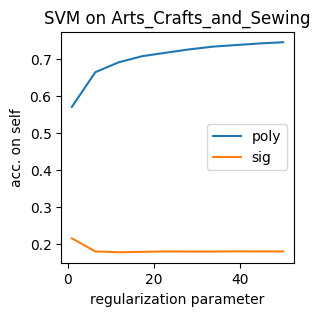

In [ ]:
#plt.plot(accuracy_lin, label='lin')

plt.figure(figsize=(3,3))

plt.plot(c_range, accuracy_poly, label='poly')
#plt.plot(c_range, accuracy_rbf, label='rbf')
plt.plot(c_range, accuracy_sig, label='sig')
plt.legend(loc="lower right")
plt.title(f'SVM on {train_name}')
plt.xlabel('regularization parameter')
plt.ylabel('acc. on self')
plt.legend(loc = 'center right')
plt.show()

In [ ]:
poly = svm.SVC(kernel='poly', degree=3, C=20, decision_function_shape='ovr').fit(train_feat, train_label)
pred_train = poly.predict(train_feat)

In [ ]:
#print(f1_score(test_label, pred, average="macro"))
#print(precision_score(test_label, pred, average="macro"))
#print(recall_score(test_label, pred, average="macro"))

precision, recall, fscore, support = score(train_label, pred_train)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.97815363 0.97659574 0.9579031  0.93962585 0.41469595]
recall: [0.694  0.6885 0.603  0.5525 0.982 ]
fscore: [0.81193331 0.80762463 0.74010433 0.69584383 0.58313539]
support: [2000 2000 2000 2000 2000]


In [ ]:
# precision, recall, fscore, support = score(val_label, pred_val)

# print('precision: {}'.format(precision))
# print('recall: {}'.format(recall))
# print('fscore: {}'.format(fscore))
# print('support: {}'.format(support))

              precision    recall  f1-score   support

         0.0       0.98      0.69      0.81      2000
         1.0       0.98      0.69      0.81      2000
         2.0       0.96      0.60      0.74      2000
         3.0       0.94      0.55      0.70      2000
         4.0       0.41      0.98      0.58      2000

    accuracy                           0.70     10000
   macro avg       0.85      0.70      0.73     10000
weighted avg       0.85      0.70      0.73     10000



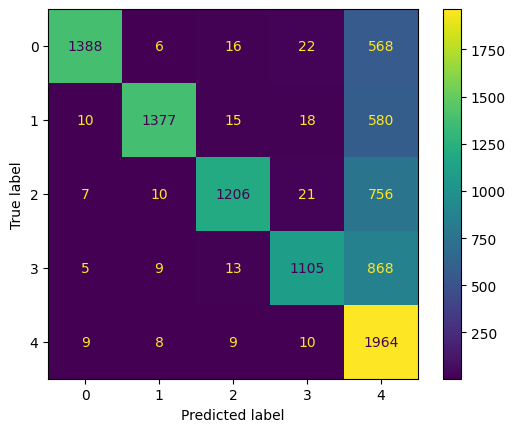

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(train_label, pred_train)).plot()
print(classification_report(train_label, pred_train))

              precision    recall  f1-score   support

         0.0       0.04      0.26      0.07       115
         1.0       0.02      0.25      0.04        64
         2.0       0.04      0.17      0.06       109
         3.0       0.06      0.06      0.06       332
         4.0       0.94      0.57      0.71      4639

    accuracy                           0.52      5259
   macro avg       0.22      0.26      0.19      5259
weighted avg       0.83      0.52      0.63      5259



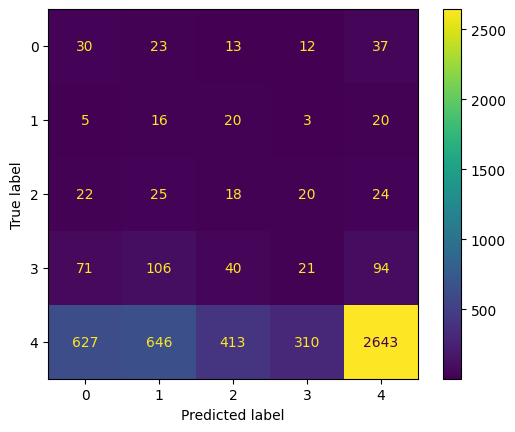

In [ ]:
pred_val = poly.predict(encoded_val)
ConfusionMatrixDisplay(confusion_matrix(val_label, pred_val)).plot()
print(classification_report(val_label, pred_val))

              precision    recall  f1-score   support

         0.0       0.03      0.20      0.05      1095
         1.0       0.05      0.25      0.09      1488
         2.0       0.13      0.16      0.14      3880
         3.0       0.26      0.11      0.16      7831
         4.0       0.67      0.39      0.50     19956

    accuracy                           0.29     34250
   macro avg       0.23      0.22      0.19     34250
weighted avg       0.47      0.29      0.35     34250



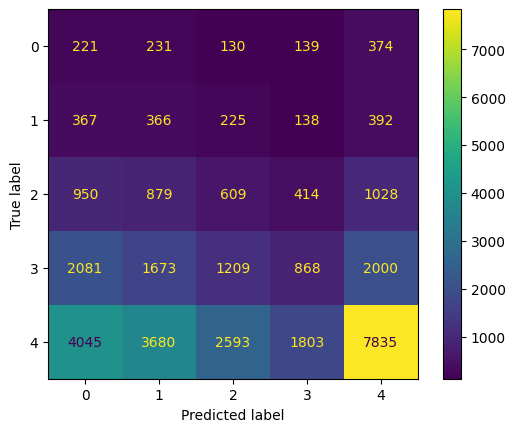

In [ ]:
pred_test = poly.predict(encoded_test)
ConfusionMatrixDisplay(confusion_matrix(y_test, pred_test)).plot()
print(classification_report(y_test, pred_test))